In [ ]:
!pip install transformers
!pip install git+https://github.com/huggingface/transformers.git@main
!pip install -q datasets
!pip install torch

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /private/var/folders/my/dq93_q7x3gx_hrc3xt13kqn00000gp/T/pip-req-build-l6ibiag_
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /private/var/folders/my/dq93_q7x3gx_hrc3xt13kqn00000gp/T/pip-req-build-l6ibiag_
  Resolved https://github.com/huggingface/transformers.git to commit 2fc33ebead50383f7707b17f0e2a178d86347d10
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.36.0.dev0-py3-none-any.whl size=7995423 sha256=c5f489ec70b85bab0a365f292b098b845b3594e92f49663dcdea5bbe8e9b92ca
  Stored in directory: /private/var/folders/my/dq93_q7x3gx_hrc3xt13kqn00000gp/T/pip-ephem-wheel-cache-05xtgydt/wheels/b1/e5/2d/f924f6ef6b8b18729da5fe63dcfd041272a65480e4aa70ee15
Successfully built transformers
  Attempting uninstall: transfor

In [ ]:
import torch
import random
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

from transformers.utils import send_example_telemetry

send_example_telemetry("Salesforce/blip-image-captioning-large", framework="pytorch")

from datasets import load_dataset

dataset = load_dataset("jpawan33/fkr30k-image-captioning-dataset", split="train")

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [ ]:
# If you want consistent results when running set random seed
# random.seed(37)

# Loading the train_dataset
train_dataset = ImageCaptioningDataset(dataset, processor)

# Get the total number of samples in the dataset
total_samples = len(train_dataset)

# Define the size of the subset you want
subset_size = 100

# Randomly select a subset of indices from the dataset
subset_indices = random.sample(range(total_samples), subset_size)

# Create a new subset dataset based on the selected indices
subset_dataset = [train_dataset[i] for i in subset_indices]

# Define the batch size for the DataLoader
batch_size = 8  # Adjust this to a batch size that works for your computer

# Create a DataLoader for the subset dataset
subset_dataloader = DataLoader(subset_dataset, shuffle=True, batch_size=batch_size)

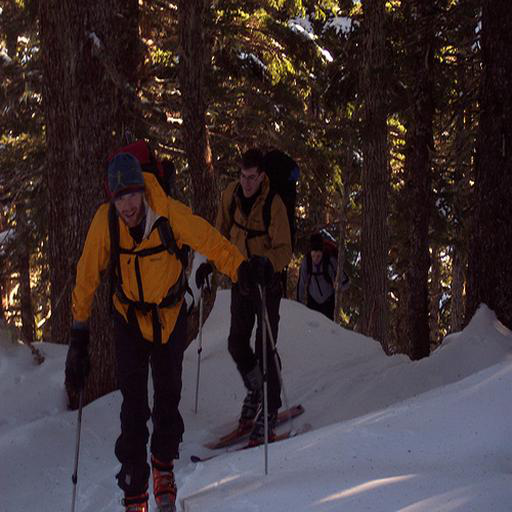

In [ ]:
example = dataset[250]
image = example["image"]
image

In [ ]:
text = example["text"]
text

'Two people wearing yellow jackets crosscountry skiing .'

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(1):
  print("Epoch:", epoch)
  for idx, batch in enumerate(subset_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 10.133584022521973
Loss: 10.029319763183594
Loss: 9.909260749816895
Loss: 9.50377082824707
Loss: 9.412192344665527
Loss: 8.929390907287598
Loss: 8.812758445739746
Loss: 8.626581192016602
Loss: 8.405117988586426
Loss: 8.286852836608887
Loss: 8.078930854797363
Loss: 7.930054664611816
Loss: 7.792664527893066


In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a man in a yellow jacket and a black hat is skiing through a forest


In [ ]:
# Save model as a pytorch model
torch.save(model, './my_model')

In [ ]:
# Save model to hugging face web need to get a unique token
model.push_to_hub("my-model", token='token')

In [ ]:
# Save processor to hugging face web need to get a unique token
processor.push_to_hub("my-processor", token='token')